In [ ]:
from google.colab import drive
drive.mount('/drive', force_remount=True)

Mounted at /drive


In [ ]:
!apt-get install build-essential python3-dev python3-numpy libhdf4-dev -y
!pip3 install pyhdf

In [ ]:
import numpy as np
from pyhdf.SD import SD, SDC
import subprocess
import os

class ModisData():
  def __init__(self, raw_data_path, image_size, data_file, image_path, anc_path, mask_path, bands, satellite='aqua'):
    if(satellite=='aqua'):
      self.radiances_pref = 'MYD021KM'
      self.cloud_pref = 'MYD35_L2'
    else:
      self.radiances_pref = 'MOD021KM'
      self.cloud_pref = 'MOD35_L2'
      
    self.raw_data_path = raw_data_path
    self.ls_path = raw_data_path.replace(' ','\ ')

    self.image_size = image_size

    self.data_file = data_file
    self.image_path = image_path
    self.anc_path = anc_path
    self.mask_path = mask_path

    self.bands = bands
    self.band_idx = {}

  def process_raw_data(self, radiance_file, cloud_file):

    print("Processing ",radiance_file)

    try:
      hdf = SD(self.raw_data_path + radiance_file, SDC.READ)
      hdf_cloud = SD(self.raw_data_path + cloud_file, SDC.READ)
    except:
      return None, None

    # generate radiances "image"
    radiance_list = []
    
    hdf_fields = {
        'EV_1KM_RefSB':'Band_1KM_RefSB',
        'EV_1KM_Emissive':'Band_1KM_Emissive',
        'EV_250_Aggr1km_RefSB':'Band_250M',
        'EV_500_Aggr1km_RefSB':'Band_500M'
    }
    

    for k,v in hdf_fields.items():
      data_raw = hdf.select(k)
      if k not in self.band_idx:
        data_bands = list(hdf.select(v).get().astype(int))
        band_list = []
        for b in self.bands:
          try:
            idx = data_bands.index(b)
            band_list.append(int(idx))
          except:
            continue
        self.band_idx[k] = band_list

      attrs = data_raw.attributes(full=1)

      aoa=attrs["radiance_offsets"]
      add_offset = aoa[0][0]
      fva=attrs["_FillValue"]
      _FillValue = fva[0]
      sfa=attrs["radiance_scales"]
      scale_factor = sfa[0][0]        
      vra=attrs["valid_range"]
      valid_min = vra[0][0]        
      valid_max = vra[0][1]        
      
      data_raw = data_raw.get()
      
      for i in self.band_idx[k]:
      #for i in range(data_raw.shape[0]):
        data = data_raw[i,:,:].astype(np.double)
        
        invalid = np.logical_or(data > valid_max,
                                data < valid_min)
        invalid = np.logical_or(invalid, data == _FillValue)

        radiance_list.append(data)
            

    radiance_data = np.stack(radiance_list, axis=2)

    # generate cloud mask image
    cloud_data_raw = hdf_cloud.select('Cloud_Mask').get()
        
    byte1_data = cloud_data_raw[0,:,:]
    bits1and2 = byte1_data & 0b00000110
    
    cloud_mask = (bits1and2 < 2).astype(int)

    ancillary_list = []

    #get scene information from cloud mask and create ancillary data
    bit3 = byte1_data & 0b00001000
    day_night = bit3.astype(int)
    ancillary_list.append(day_night)

    bit4 = byte1_data & 0b00010000
    sunglint = bit4.astype(int)
    ancillary_list.append(sunglint)

    bit5 = byte1_data & 0b00100000
    snow_ice = bit5.astype(int)
    ancillary_list.append(snow_ice)

    bits6and7 = byte1_data & 0b11000000
    land_water = bits6and7.astype(int)
    ancillary_list.append(land_water)

    ancillary_data = np.stack(ancillary_list, axis=2)
    
    return radiance_data, ancillary_data, cloud_mask

    
  def get_file_pair(self, date, time):

    pattern = 'ls {} | grep {}.A{}.{}.061'

    radiance_cmd = pattern.format(self.ls_path, self.radiances_pref, date, time)
    radiance_file = subprocess.run(radiance_cmd, stdout=subprocess.PIPE, shell=True).stdout.rstrip().decode('utf-8')

    cloud_cmd = pattern.format(self.ls_path, self.cloud_pref, date, time)
    cloud_file = subprocess.run(cloud_cmd, stdout=subprocess.PIPE, shell=True).stdout.rstrip().decode('utf-8')
    
    return radiance_file or None, cloud_file or None


  def add_to_dataset(self, image, ancdata, mask, name):
    
    path = name.split('.')
    subpath = path[0] + '/' + path[1]

    imagepath = [self.image_path, self.image_path + path[0], self.image_path + subpath]
    for p in imagepath:
      if not os.path.isdir(p):  
        os.mkdir(p)

    ancpath = [self.anc_path, self.anc_path + path[0], self.anc_path + subpath]
    for p in ancpath:
      if not os.path.isdir(p):  
        os.mkdir(p)

    maskpath = [self.mask_path, self.mask_path + path[0], self.mask_path + subpath]
    for p in maskpath:
      if not os.path.isdir(p):  
        os.mkdir(p)

    imagepath = imagepath[2]
    ancpath = ancpath[2]
    maskpath = maskpath[2]

    f = open(self.data_file,'a')

    increment = self.image_size

    imax = image.shape[0] + 1
    jmax = image.shape[1] + 1

    for i in range(0,imax,increment):
      for j in range(0,jmax,increment):
        
        starti = i
        endi = starti + increment
        if endi >= imax:
          endi = -1
          starti = endi - increment
            
        startj = j
        endj = startj + increment
        if endj >= jmax:
          endj = -1
          startj = endj - increment
        
        image_chunk = image[starti:endi,startj:endj,:]
        anc_chunk = ancdata[starti:endi,startj:endj,:]
        mask_chunk = mask[starti:endi,startj:endj]

        data_name = '/{}-{}.npy'.format(i,j)

        np.save(imagepath + data_name, image_chunk)
        np.save(ancpath + data_name, anc_chunk)
        np.save(maskpath + data_name, mask_chunk)

        f.write(subpath + data_name + '\n')

    f.close()


  def process_file_pair(self, radiance_file, cloud_file):
    image, ancdata, mask = self.process_raw_data(radiance_file, cloud_file)

    if image is not None:
      pattern = radiance_file.split('.')
      name = '{}.{}'.format(pattern[1],pattern[2])
      self.add_to_dataset(image, ancdata, mask, name)

  def process_bulk_files(self, date_list, time_start=0, time_end=2400):
    counter = 0
    for date in date_list:
      for n in range(time_start,time_end,5):
        time = str(n)
        if n < 1000:
          time = '0' + time
        if n < 100:
          time = '0' + time
        if n < 10:
          time = '0' + time

        filepair = self.get_file_pair(date, time)

        if all(filepair):
          counter += 1
          radiance_file, cloud_file = filepair
          self.process_file_pair(radiance_file, cloud_file)
        else:
          continue


In [ ]:
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_files, images=None, masks=None, ancillary=None, ancillary_mode=0, batch_size=1, dim=(None,None), n_channels=1, shuffle=True, to_fit=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.images = images
        self.ancillary = ancillary
        self.masks = masks
        self.list_files = list_files
        self.ancillary_mode = ancillary_mode
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.to_fit = to_fit
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_files) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_files_temp = [self.list_files[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_files_temp)
        if self.to_fit:
            return X, y
        else:
            return X

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_files_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        if(self.ancillary_mode==2):
          Z = np.empty((self.batch_size, *self.dim, 4)) 

        # Generate data
        for i, f in enumerate(list_files_temp):
            # Store image
            image = np.load(self.images + f)

            if(self.ancillary_mode):
              # Store ancillary
              ancillary = np.load(self.ancillary + f)
              if(self.ancillary_mode==1):
                image = np.dstack((image,ancillary))
              else:
                Z[i,] = ancillary

            X[i,] = image

            # Store mask
            mask = np.load(self.masks + f)
            mask = np.reshape(mask, (*self.dim, -1)) 
            y[i] = mask

        if(self.ancillary_mode==2):
          return [X, Z], y
        else:
          return X, y
    

In [ ]:
class DataSettings():
  def __init__(self, image_size=32, bands=False, project_path='/drive/My Drive/School/csc594/project/'):
    self.image_size = image_size
    if not bands:
      self.bands = [1,2,3,5,7,20,26,27,29,31,32,33]
    else:
      self.bands = bands
    self.channels = len(self.bands)

    self.project_path = project_path
    self.data_path = project_path + 'modis-aqua/'
    self.data_file = '{}data{}.txt'.format(project_path,image_size)
    self.image_path = '{}images/{}-{}/'.format(project_path,image_size,self.channels)
    self.anc_path = '{}ancillary/{}/'.format(project_path,image_size)
    self.mask_path = '{}masks/{}/'.format(project_path,image_size)

In [ ]:
class Dataset():
  def __init__(self, settings, batch_size=32, ancillary_mode=0):
    self.settings = settings
    self.channels = settings.channels
    self.batch_size = batch_size
    self.ancillary_mode = ancillary_mode
    if(ancillary_mode==1):
      self.channels += 4
    self.image_dim = (settings.image_size, settings.image_size)
    self.input_size = (settings.image_size, settings.image_size, self.channels)
    self.ancillary_input_size = (settings.image_size, settings.image_size, 4)

    with open(self.settings.data_file,'r') as f:
      self.files = f.read().splitlines()

    print("Total data: ",len(self.files))

    # split file list into train and test lists for generator
    train, test = train_test_split(self.files, train_size=0.8, random_state=42)
    train, val = train_test_split(train, train_size=0.9, random_state=42)
    test, pred = train_test_split(test, test_size=0.5, random_state=42)
    self.pred = pred

    print("Train: ",len(train))
    print("Val: ",len(val))
    print("Test: ",len(test))
    print("Pred: ",len(pred))

    # Parameters
    params = {'images':self.settings.image_path,
              'masks':self.settings.mask_path,
              'ancillary':self.settings.anc_path,
              'ancillary_mode':self.ancillary_mode,
              'batch_size': self.batch_size,
              'dim': self.image_dim,
              'n_channels': self.channels,
              'shuffle': True}

    # Generators
    self.training_generator = DataGenerator(train, **params)
    self.validation_generator = DataGenerator(val, **params)
    self.test_generator = DataGenerator(test, **params)
    self.pred_generator = DataGenerator(pred, **params, to_fit=False)

In [ ]:
settings = DataSettings()

modis = ModisData(
    settings.data_path, 
    settings.image_size, 
    settings.data_file, 
    settings.image_path, 
    settings.anc_path, 
    settings.mask_path, 
    settings.bands)

dates = ['2019032','2019152','2019274','2019182']
modis.process_bulk_files(dates)

Processing  MYD021KM.A2019032.0000.061.2019032152242.hdf
Processing  MYD021KM.A2019032.0005.061.2019032152230.hdf
Processing  MYD021KM.A2019032.0010.061.2019032152339.hdf
Processing  MYD021KM.A2019032.0015.061.2019032152346.hdf
Processing  MYD021KM.A2019182.0000.061.2019182153303.hdf
Processing  MYD021KM.A2019182.0005.061.2019182153252.hdf
Processing  MYD021KM.A2019182.0055.061.2019182154008.hdf
Processing  MYD021KM.A2019182.0100.061.2019182152520.hdf
Processing  MYD021KM.A2019182.0105.061.2019182152500.hdf
Processing  MYD021KM.A2019182.0110.061.2019182152416.hdf
Processing  MYD021KM.A2019182.0115.061.2019182153340.hdf
Processing  MYD021KM.A2019182.0120.061.2019182153251.hdf
Processing  MYD021KM.A2019182.1450.061.2019183153657.hdf
Processing  MYD021KM.A2019182.1455.061.2019183153556.hdf


Total data:  5504
Train:  3962
Val:  441
Test:  550
Pred:  551


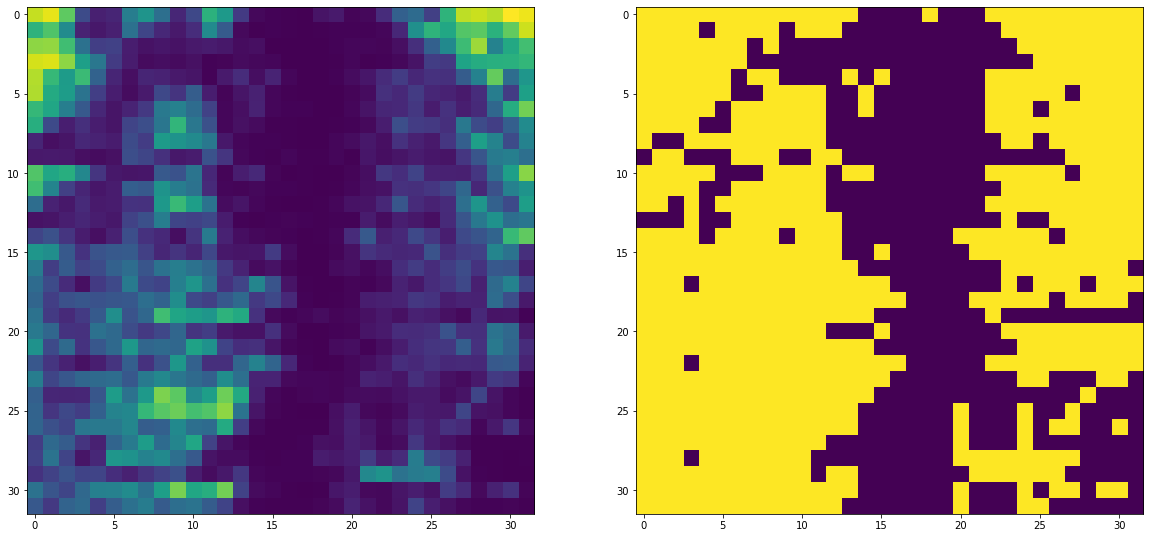

In [ ]:
# Show some demo data
settings = DataSettings() 
dataset = Dataset(settings)

fig=plt.figure(figsize=(20,20))

image=np.load(settings.image_path+dataset.files[1], allow_pickle=True)
plt.subplot(1, 2, 1)
plt.imshow(image[:,:,11])

mask=np.load(settings.mask_path+dataset.files[1], allow_pickle=True)
plt.subplot(1, 2, 2)
plt.imshow(mask[:,:])

plt.show()

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, UpSampling2D, Conv2D, MaxPooling2D, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Dense, SeparableConv2D

In [ ]:
def run_model(model, dataset, settings):
  weightsfile = settings.project_path + model.name + '-weights.h5'
  callbacks = [
      EarlyStopping(monitor='acc', patience=10, verbose=1),
      ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=5, min_lr=1e-10, verbose=1),
      ModelCheckpoint(weightsfile, verbose=1, save_best_only=True, save_weights_only=True)
  ]

  results = model.fit_generator(generator=dataset.training_generator, validation_data=dataset.validation_generator, 
                                    use_multiprocessing=True, workers=8, callbacks=callbacks, epochs=600)
  
  return weightsfile, results

In [ ]:
def plot_learning(model, results):
  plt.style.use("ggplot")
  plt.figure(figsize=(8, 8))
  plt.title(model.name + "learning curve")
  plt.plot(results.history["loss"], label="loss")
  plt.plot(results.history["acc"], label="acc")
  plt.plot(results.history["val_loss"], label="val_loss")
  plt.plot(results.history["val_acc"], label="val_acc")
  plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
  plt.xlabel("Epochs")
  plt.ylabel("log_loss")
  plt.legend()

In [ ]:
def evaluate_model(model, weights, dataset):
  model.load_weights(weights)
  model.evaluate_generator(generator=dataset.test_generator, verbose=1, use_multiprocessing=True, workers=8)

In [ ]:
def save_and_predict(model, dataset, settings):
  model.save(settings.project_path + model.name + '.h5')
  prediction = model.predict_generator(generator=dataset.pred_generator, verbose=1, use_multiprocessing=True, workers=8)
  return prediction

In [ ]:
def plot_predictions(predictions, sample_num, channel_num, confidence, dataset, settings):
  fig=plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)

  if(dataset.ancillary_mode==2):
    original = dataset.pred_generator[0][0][sample_num]
  else:
    original = dataset.pred_generator[0][sample_num]
  plt.imshow(original[:,:,channel_num])

  plt.subplot(1, 2, 2)
  prediction = predictions[sample_num]
  prediction = np.reshape(prediction, (prediction.shape[0],prediction.shape[1]))
  plt.imshow((prediction>confidence))

  plt.show()

In [ ]:
def unet(input_size, growth_factor = 2, kernel_size = 3, strides = 1, pool_size = 2, dropout = 0.1):
    
    inputs = Input(input_size)
    output_features = input_size[2]

    commonparams = {
        'strides': strides, 
        'kernel_initializer': 'he_normal', 
        'padding': 'same', 
        'activation': 'relu'
    }

    # Contracting Path
    output_features *= growth_factor
    c1 = Conv2D(output_features, kernel_size = kernel_size, **commonparams)(inputs)
    c1 = Conv2D(output_features, kernel_size = kernel_size, **commonparams)(c1)
    p1 = MaxPooling2D(pool_size)(c1)

    output_features *= growth_factor
    c2 = Conv2D(output_features, kernel_size = kernel_size, **commonparams)(p1)
    c2 = Conv2D(output_features, kernel_size = kernel_size, **commonparams)(c2)
    p2 = MaxPooling2D(pool_size)(c2)
    
    output_features *= growth_factor
    c3 = Conv2D(output_features, kernel_size = kernel_size, **commonparams)(p2)
    c3 = Conv2D(output_features, kernel_size = kernel_size, **commonparams)(c3)
    p3 = MaxPooling2D(pool_size)(c3)
    
    output_features *= growth_factor
    c4 = Conv2D(output_features, kernel_size = kernel_size, **commonparams)(p3)
    c4 = Conv2D(output_features, kernel_size = kernel_size, **commonparams)(c4)
    p4 = MaxPooling2D(pool_size)(c4)
    
    output_features *= growth_factor
    c5 = Conv2D(output_features, kernel_size = kernel_size, **commonparams)(p4)
    c5 = Conv2D(output_features, kernel_size = kernel_size, **commonparams)(c5)
    p5 = Dropout(dropout)(c5)
    
    # Expansive Path
    output_features //= growth_factor
    u6 = UpSampling2D(size = (2,2))(p5)
    u6 = Conv2D(output_features, kernel_size = 2, **commonparams)(u6)
    u6 = concatenate([u6, c4], axis = 3)
    c6 = Conv2D(output_features, kernel_size = kernel_size, **commonparams)(u6)
    c6 = Conv2D(output_features, kernel_size = kernel_size, **commonparams)(c6)
    
    output_features //= growth_factor
    u7 = UpSampling2D(size = (2,2))(c6)
    u7 = Conv2D(output_features, kernel_size = 2, **commonparams)(u7)
    u7 = concatenate([u7, c3], axis = 3)
    c7 = Conv2D(output_features, kernel_size = kernel_size, **commonparams)(u7)
    c7 = Conv2D(output_features, kernel_size = kernel_size, **commonparams)(c7)

    output_features //= growth_factor    
    u8 = UpSampling2D(size = (2,2))(c7)
    u8 = Conv2D(output_features, kernel_size = 2, **commonparams)(u8)
    u8 = concatenate([u8, c2], axis = 3)
    c8 = Conv2D(output_features, kernel_size = kernel_size, **commonparams)(u8)
    c8 = Conv2D(output_features, kernel_size = kernel_size, **commonparams)(c8)
    
    output_features //= growth_factor
    u9 = UpSampling2D(size = (2,2))(c8)
    u9 = Conv2D(output_features, kernel_size = 2, **commonparams)(u9)
    u9 = concatenate([u9, c1], axis = 3)
    c9 = Conv2D(output_features, kernel_size = kernel_size, **commonparams)(u9)
    c9 = Conv2D(output_features, kernel_size = kernel_size, **commonparams)(c9)

    c9 = Conv2D(2, kernel_size = kernel_size, **commonparams)(c9)
    outputs = Conv2D(1, 1, activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs], name = 'unet')
    return model

In [ ]:
def unet_fusion_base(input_size, growth_factor = 2, kernel_size = 3, strides = 1, pool_size = 2, dropout = 0.1, name=''):
    
    inputs = Input(input_size, name=name+'_input')
    output_features = input_size[2]

    commonparams = {
        'strides': strides, 
        'kernel_initializer': 'he_normal', 
        'padding': 'same', 
        'activation': 'relu'
    }

    # Contracting Path
    output_features *= growth_factor
    c1 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_contr1_conv1', **commonparams)(inputs)
    c1 = SeparableConv2D(output_features, kernel_size = 1, name=name+'_contr1_conv2', **commonparams)(c1)
    c1 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_contr1_conv3', **commonparams)(c1)
    c1_2 = Conv2D(output_features, kernel_size = 1, name=name+'_contr1_conv4', **commonparams)(inputs)
    c1_2 = concatenate([c1, c1_2], name=name+'_contr1_conc', axis = 3)
    c1 = BatchNormalization(name=name+'_contr1_batch')(c1_2)
    p1 = MaxPooling2D(pool_size, name=name+'_contr1_pool')(c1)

    output_features *= growth_factor
    c2 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_contr2_conv1', **commonparams)(p1)
    c2 = SeparableConv2D(output_features, kernel_size = 1, name=name+'_contr2_conv2', **commonparams)(c2)
    c2 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_contr2_conv3', **commonparams)(c2)
    c2_2 = Conv2D(output_features, kernel_size = 1, name=name+'_contr2_conv4', **commonparams)(p1)
    c2_2 = concatenate([c2, c2_2], name=name+'_contr2_conc', axis = 3)
    c2 = BatchNormalization(name=name+'_contr2_batch')(c2_2)
    p2 = MaxPooling2D(pool_size, name=name+'_contr2_pool')(c2)
    
    output_features *= growth_factor
    c3 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_contr3_conv1', **commonparams)(p2)
    c3 = SeparableConv2D(output_features, kernel_size = 1, name=name+'_contr3_conv2', **commonparams)(c3)
    c3 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_contr3_conv3', **commonparams)(c3)
    c3_2 = Conv2D(output_features, kernel_size = 1, name=name+'_contr3_conv4', **commonparams)(p2)
    c3_2 = concatenate([c3, c3_2], name=name+'_contr3_conc', axis = 3)
    c3 = BatchNormalization(name=name+'_contr3_batch')(c3_2)
    p3 = MaxPooling2D(pool_size, name=name+'_contr3_pool')(c3)
    
    output_features *= growth_factor
    c4 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_contr4_conv1', **commonparams)(p3)
    c4 = SeparableConv2D(output_features, kernel_size = 1, name=name+'_contr4_conv2', **commonparams)(c4)
    c4 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_contr4_conv3', **commonparams)(c4)
    c4_2 = Conv2D(output_features, kernel_size = 1, name=name+'_contr4_conv4', **commonparams)(p3)
    c4_2 = concatenate([c4, c4_2], name=name+'_contr4_conc', axis = 3)
    c4 = BatchNormalization(name=name+'_contr4_batch')(c4_2)
    p4 = MaxPooling2D(pool_size, name=name+'_contr4_pool')(c4)
    
    output_features *= growth_factor
    c5 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_contr5_conv1', **commonparams)(p4)
    c5 = SeparableConv2D(output_features, kernel_size = 1, name=name+'_contr5_conv2', **commonparams)(c5)
    c5 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_contr5_conv3', **commonparams)(c5)
    c5_2 = Conv2D(output_features, kernel_size = 1, name=name+'_contr5_conv4', **commonparams)(p4)
    c5_2 = concatenate([c5, c5_2], name=name+'_contr5_conc', axis = 3)
    c5 = BatchNormalization(name=name+'_contr5_batch')(c5_2)
    p5 = MaxPooling2D(pool_size, name=name+'_contr5_pool')(c5)
    
    output_features *= growth_factor
    c6 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_contr6_conv1', **commonparams)(p5)
    c6 = Conv2D(output_features, kernel_size = 1, name=name+'_contr6_conv2', **commonparams)(c6)
    c6 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_contr6_conv3', **commonparams)(c6)
    p6 = Dropout(dropout, name=name+'_contr6_dropout')(c6)
    
    # Expansive Path
    output_features //= growth_factor
    u7 = UpSampling2D(name=name+'_exp1_up', size = (2,2))(p6)
    u7 = Conv2D(output_features, kernel_size = 2, name=name+'_exp1_conv1', **commonparams)(u7)
    u7 = concatenate([u7, c5, p4], name=name+'_exp1_conc', axis = 3)
    c7 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_exp1_conv2', **commonparams)(u7)
    c7 = SeparableConv2D(output_features, kernel_size = 1, name=name+'_exp1_conv3', **commonparams)(c7)
    c7 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_exp1_conv4', **commonparams)(c7)

    output_features //= growth_factor    
    u8 = UpSampling2D(name=name+'_exp2_up', size = (2,2))(c7)
    u8 = Conv2D(output_features, kernel_size = 2, name=name+'_exp2_conv1', **commonparams)(u8)
    u8 = concatenate([u8, c4, p3], name=name+'_exp2_conc', axis = 3)
    c8 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_exp2_conv2', **commonparams)(u8)
    c8 = SeparableConv2D(output_features, kernel_size = 1, name=name+'_exp2_conv3', **commonparams)(c8)
    c8 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_exp2_conv4', **commonparams)(c8)
    
    output_features //= growth_factor
    u9 = UpSampling2D(name=name+'_exp3_up', size = (2,2))(c8)
    u9 = Conv2D(output_features, kernel_size = 2, name=name+'_exp3_conv1', **commonparams)(u9)
    u9 = concatenate([u9, c3, p2], name=name+'_exp3_conc', axis = 3)
    c9 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_exp3_conv2', **commonparams)(u9)
    c9 = SeparableConv2D(output_features, kernel_size = 1, name=name+'_exp3_conv3', **commonparams)(c9)
    c9 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_exp3_conv4', **commonparams)(c9)

    output_features //= growth_factor
    u10 = UpSampling2D(name=name+'_exp4_up', size = (2,2))(c9)
    u10 = Conv2D(output_features, kernel_size = 2, name=name+'_exp4_conv1', **commonparams)(u10)
    u10 = concatenate([u10, c2, p1], name=name+'_exp4_conc', axis = 3)
    c10 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_exp4_conv2', **commonparams)(u10)
    c10 = SeparableConv2D(output_features, kernel_size = 1, name=name+'_exp4_conv3', **commonparams)(c10)
    c10 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_exp4_conv4', **commonparams)(c10)

    output_features //= growth_factor
    u11 = UpSampling2D(name=name+'_exp5_up', size = (2,2))(c10)
    u11 = Conv2D(output_features, kernel_size = 2, name=name+'_exp5_conv1', **commonparams)(u11)
    u11 = concatenate([u11, c1], name=name+'_exp5_conc', axis = 3)
    c11 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_exp5_conv2', **commonparams)(u11)
    c11 = SeparableConv2D(output_features, kernel_size = 1, name=name+'_exp5_conv3', **commonparams)(c11)
    c11 = Conv2D(output_features, kernel_size = kernel_size, name=name+'_exp5_conv4', **commonparams)(c11)

    outputs = Conv2D(output_features, kernel_size = kernel_size, **commonparams)(c11)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
def unet_fusion_stacked(input_size, growth_factor = 2, kernel_size = 3, strides = 1, pool_size = 2, dropout = 0.1):
    
    base_model = unet_fusion_base(input_size, growth_factor, kernel_size, strides, pool_size, dropout, name='stacked')

    top = Conv2D(2, kernel_size = kernel_size, strides=strides, kernel_initializer='he_normal', padding='same', activation='relu')(base_model.output)
    top = Conv2D(1, 1, activation='sigmoid')(top)
    model = Model(inputs=[base_model.input], outputs=[top], name = 'unet_fusion_stacked')

    return model

In [ ]:
def unet_fusion_separate(image_input_size, ancillary_input_size, growth_factor = 2, kernel_size = 3, strides = 1, pool_size = 2, dropout = 0.1):
    
    image_model = unet_fusion_base(image_input_size, growth_factor, kernel_size, strides, pool_size, dropout, name='image')

    ancillary_model = unet_fusion_base(ancillary_input_size, growth_factor, kernel_size, strides, pool_size, dropout, name='ancillary')

    combined = concatenate([image_model.output, ancillary_model.output])
    combined = Conv2D(2, kernel_size = kernel_size, strides=strides, kernel_initializer='he_normal', padding='same', activation='relu')(combined)
    combined = Conv2D(1, 1, activation='sigmoid')(combined)
    model = Model(inputs=[image_model.input, ancillary_model.input], outputs=[combined], name = 'unet_fusion_separate')

    return model

In [ ]:
# Use default data settings for these runs
settings = DataSettings() 

In [ ]:
# Try basic U-Net model
unet_dataset = Dataset(settings)

unet_model = unet(dataset.input_size)
unet_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=["accuracy"])
unet_model.summary()

Total data:  5504
Train:  3962
Val:  441
Test:  550
Pred:  551
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 12)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 24)   2616        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 24)   5208        conv2d[0][0]                     
_______________________________________________________

In [ ]:
unet_weights, unet_results = run_model(unet_model, dataset, settings)

Epoch 1/600
 95/866 [==>...........................] - ETA: 1:18 - loss: 0.6760 - acc: 0.6892
Epoch 00001: val_loss improved from inf to 0.67615, saving model to /drive/My Drive/School/csc594/project/unet-weights.h5
866/866 [==============================] - 100s 115ms/step - loss: 5.8646 - acc: 0.6708 - val_loss: 0.6762 - val_acc: 0.6875
Epoch 2/600
865/866 [============================>.] - ETA: 0s - loss: 0.6770 - acc: 0.6782Epoch 1/600
Epoch 1/600
 94/866 [==>...........................] - ETA: 1:19 - loss: 0.6684 - acc: 0.6879
Epoch 00002: val_loss improved from 0.67615 to 0.66847, saving model to /drive/My Drive/School/csc594/project/unet-weights.h5
866/866 [==============================] - 85s 98ms/step - loss: 0.6770 - acc: 0.6782 - val_loss: 0.6685 - val_acc: 0.6875
Epoch 3/600
 94/866 [==>...........................] - ETA: 1:16 - loss: 0.6586 - acc: 0.6880
Epoch 00003: val_loss improved from 0.66847 to 0.65871, saving model to /drive/My Drive/School/csc594/project/unet-weig

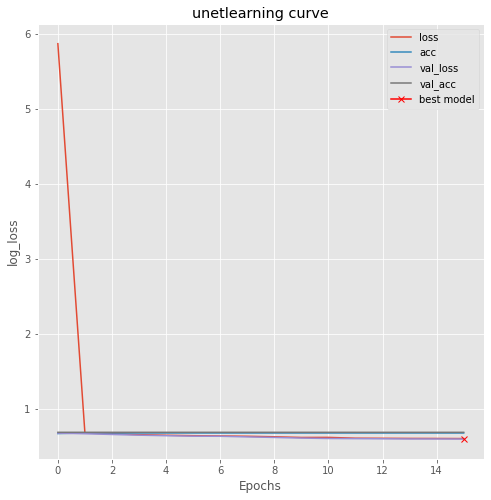

In [ ]:
plot_learning(unet_model, unet_results)

In [ ]:
evaluate_model(unet_model, unet_weights, dataset)

120/120 [==============================] - 11s 89ms/step - loss: 0.6016 - acc: 0.6813


120/120 [==============================] - 11s 91ms/step


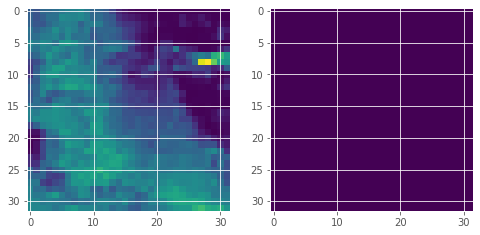

In [ ]:
unet_predictions = save_and_predict(unet_model, dataset, settings)
plot_predictions(unet_predictions, 0, 11, 0.5, dataset, settings)

In [ ]:
# Try modified U-Net with fusion at the feature level
dataset = Dataset(settings, ancillary_mode=1)

unet_fusion_stacked = unet_fusion_stacked(dataset.input_size)
unet_fusion_stacked.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=["accuracy"])
unet_fusion_stacked.summary()

Total data:  40442
Train:  29117
Val:  3236
Test:  4044
Pred:  4045
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "unet_fusion_stacked"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
stacked_input (InputLayer)      [(None, 32, 32, 16)] 0                                            
__________________________________________________________________________________________________
stacked_contr1_conv1 (Conv2D)   (None, 32, 32, 32)   4640        stacked_input[0][0]              
__________________________________________________________________________________________________
stacked_contr1_conv2 (Separable (None, 32, 32, 32)   1088        stacked_contr1_conv1[0][0]       
___________________________________

In [ ]:
unet_fusion_stacked_weights, unet_fusion_stacked_results = run_model(unet_fusion_stacked, dataset, settings)

Epoch 1/600
 96/866 [==>...........................]
Epoch 00001: val_loss improved from inf to 0.25245, saving model to /drive/My Drive/School/csc594/project/unet_fusion_stacked-weights.h5
866/866 [==============================] - 153s 176ms/step - loss: 0.2783 - acc: 0.8793 - val_loss: 0.2524 - val_acc: 0.8850
Epoch 2/600
 95/866 [==>...........................] - ETA: 1:50 - loss: 0.1854 - acc: 0.9138
Epoch 00002: val_loss improved from 0.25245 to 0.18580, saving model to /drive/My Drive/School/csc594/project/unet_fusion_stacked-weights.h5
866/866 [==============================] - 134s 155ms/step - loss: 0.1967 - acc: 0.9109 - val_loss: 0.1858 - val_acc: 0.9136
Epoch 3/600
 94/866 [==>...........................] - ETA: 1:56 - loss: 0.1613 - acc: 0.9265
Epoch 00003: val_loss improved from 0.18580 to 0.16178, saving model to /drive/My Drive/School/csc594/project/unet_fusion_stacked-weights.h5
866/866 [==============================] - 132s 153ms/step - loss: 0.1743 - acc: 0.9197 - 

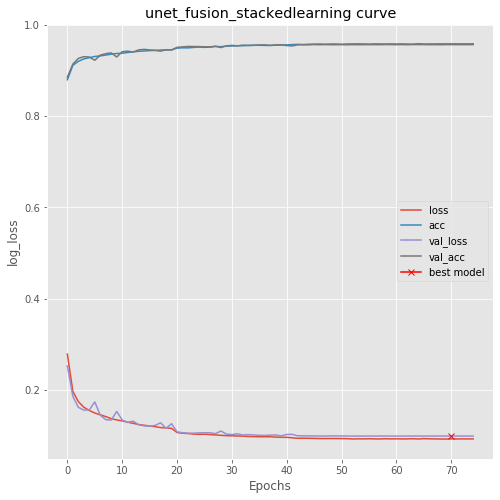

In [ ]:
plot_learning(unet_fusion_stacked, unet_fusion_stacked_results)

In [ ]:
evaluate_model(unet_fusion_stacked, unet_fusion_stacked_weights, dataset)

126/126 [==============================] - 16s 123ms/step - loss: 0.1292 - acc: 0.9370


126/126 [==============================] - 16s 127ms/step


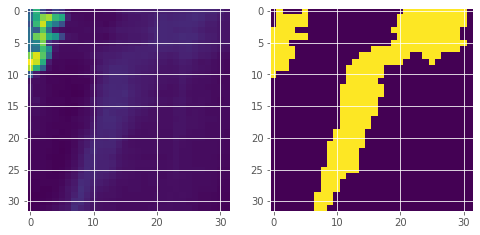

In [ ]:
unet_fusion_stacked_predictions = save_and_predict(unet_fusion_stacked, dataset, settings)
plot_predictions(unet_fusion_stacked_predictions, 0, 11, 0.95, dataset, settings)

In [ ]:
# Try modified U-Net with fusion at the classifier level
dataset = Dataset(settings, ancillary_mode=2)

unet_fusion_separate = unet_fusion_separate(dataset.input_size, dataset.ancillary_input_size)
unet_fusion_separate.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=["accuracy"])
unet_fusion_separate.summary()

Total data:  40442
Train:  29117
Val:  3236
Test:  4044
Pred:  4045
Model: "unet_fusion_separate"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 32, 32, 12)] 0                                            
__________________________________________________________________________________________________
ancillary_input (InputLayer)    [(None, 32, 32, 4)]  0                                            
__________________________________________________________________________________________________
image_contr1_conv1 (Conv2D)     (None, 32, 32, 24)   2616        image_input[0][0]                
__________________________________________________________________________________________________
ancillary_contr1_conv1 (Conv2D) (None, 32, 32, 8)    296         ancillary_input[0][0]            
___________

In [ ]:
unet_fusion_separate_weights, unet_fusion_separate_results = run_model(unet_fusion_separate, dataset, settings)

Epoch 1/600
 96/866 [==>...........................] - ETA: 1:56 - loss: 0.5436 - acc: 0.9143
Epoch 00001: val_loss improved from inf to 0.54365, saving model to /drive/My Drive/School/csc594/project/unet_fusion_separate-weights.h5
866/866 [==============================] - 163s 188ms/step - loss: 0.5873 - acc: 0.8613 - val_loss: 0.5436 - val_acc: 0.9143
Epoch 2/600
 95/866 [==>...........................] - ETA: 1:43 - loss: 0.5102 - acc: 0.9205
Epoch 00002: val_loss improved from 0.54365 to 0.51081, saving model to /drive/My Drive/School/csc594/project/unet_fusion_separate-weights.h5Epoch 1/600

866/866 [==============================] - 128s 148ms/step - loss: 0.5265 - acc: 0.9144 - val_loss: 0.5108 - val_acc: 0.9207
Epoch 3/600
 96/866 [==>...........................] - ETA: 1:43 - loss: 0.4750 - acc: 0.9318
Epoch 00003: val_loss improved from 0.51081 to 0.47505, saving model to /drive/My Drive/School/csc594/project/unet_fusion_separate-weights.h5

866/866 [========================

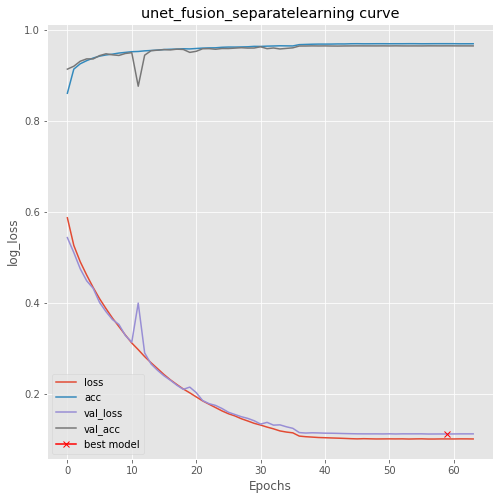

In [ ]:
plot_learning(unet_fusion_separate, unet_fusion_separate_results)

In [ ]:
evaluate_model(unet_fusion_separate, unet_fusion_separate_weights, dataset)

126/126 [==============================] - 16s 124ms/step - loss: 0.1569 - acc: 0.9497


In [ ]:
unet_fusion_separate_predictions = save_and_predict(unet_fusion_separate, dataset, settings)

126/126 [==============================] - 18s 142ms/step


In [ ]:
settings = DataSettings()

modis = ModisData(
    settings.data_path, 
    settings.image_size, 
    settings.data_file, 
    settings.image_path, 
    settings.anc_path, 
    settings.mask_path, 
    settings.bands)

radiance_files = ['MYD021KM.A2020061.0000.061.2020061155432.hdf','MYD021KM.A2020061.0045.061.2020061155550.hdf','MYD021KM.A2020061.0150.061.2020061155545.hdf']
cloud_files = ['MYD35_L2.A2020061.0000.061.2020061155543.hdf','MYD35_L2.A2020061.0045.061.2020061155818.hdf','MYD35_L2.A2020061.0150.061.2020061155700.hdf']
radiance_data = []
anc_data = [] 
mask_data = []
stacked_data = []
for i in range(len(radiance_files)):
  radiance_file = radiance_files[i]
  cloud_file = cloud_files[i]
  radiance, anc, mask = modis.process_raw_data(radiance_file, cloud_file)
  radiance_data.append(radiance[:1024,:1024,:])
  anc_data.append(anc[:1024,:1024,:])
  mask_data.append(mask[:1024,:1024])
  stacked_data.append(np.dstack((radiance,anc))[:1024,:1024,:])

Processing  MYD021KM.A2020061.0000.061.2020061155432.hdf
Processing  MYD021KM.A2020061.0045.061.2020061155550.hdf
Processing  MYD021KM.A2020061.0150.061.2020061155545.hdf


In [ ]:
radiance_data = np.asarray(radiance_data)
anc_data = np.asarray(anc_data)
mask_data = np.asarray(mask_data)
stacked_data = np.asarray(stacked_data)
radiance_data.shape

(3, 1024, 1024, 12)

In [ ]:
stacked_data = np.dstack((radiance_data,anc_data))[:1024,:1024,:]
stacked_data.shape

(1024, 1024, 16)

In [ ]:
from keras.models import load_model

unet_fusion_stacked = unet_fusion_stacked(stacked_data[0].shape)
unet_fusion_stacked.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=["accuracy"])
#stacked_data = np.reshape(stacked_data, (1, stacked_data.shape[0], stacked_data.shape[1], stacked_data.shape[2]))
unet_fusion_stacked.load_weights(settings.project_path + 'unet_fusion_stacked-weights.h5')
stacked_prediction = unet_fusion_stacked.predict(stacked_data, verbose=1)

3/3 [==============================] - 3s 1s/sample


In [ ]:
##radiance = radiance_data[:1024,:1024,:]
#ancillary = anc_data[:1024,:1024,:]
unet_fusion_separate = unet_fusion_separate(radiance_data[0].shape, anc_data[0].shape)
unet_fusion_separate.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=["accuracy"])
#radiance = np.reshape(radiance, (1, radiance.shape[0], radiance.shape[1], radiance.shape[2]))
#ancillary = np.reshape(ancillary, (1, ancillary.shape[0], ancillary.shape[1], ancillary.shape[2]))
unet_fusion_separate.load_weights(settings.project_path + 'unet_fusion_separate-weights.h5')
separate_prediction = unet_fusion_separate.predict([radiance_data, anc_data], verbose=1)

3/3 [==============================] - 4s 1s/sample


In [ ]:
stacked_prediction.shape

(3, 1024, 1024, 1)

In [ ]:
for i in stacked_prediction.shape[0]:
  stacked_prediction[i] = np.reshape(stacked_prediction[i], (stacked_prediction[i].shape[0],stacked_prediction[i].shape[1]))

for i in separate_prediction.shape[0]:
  separate_prediction[i] = np.reshape(separate_prediction[i], (separate_prediction[i].shape[0],separate_prediction[i].shape[1]))

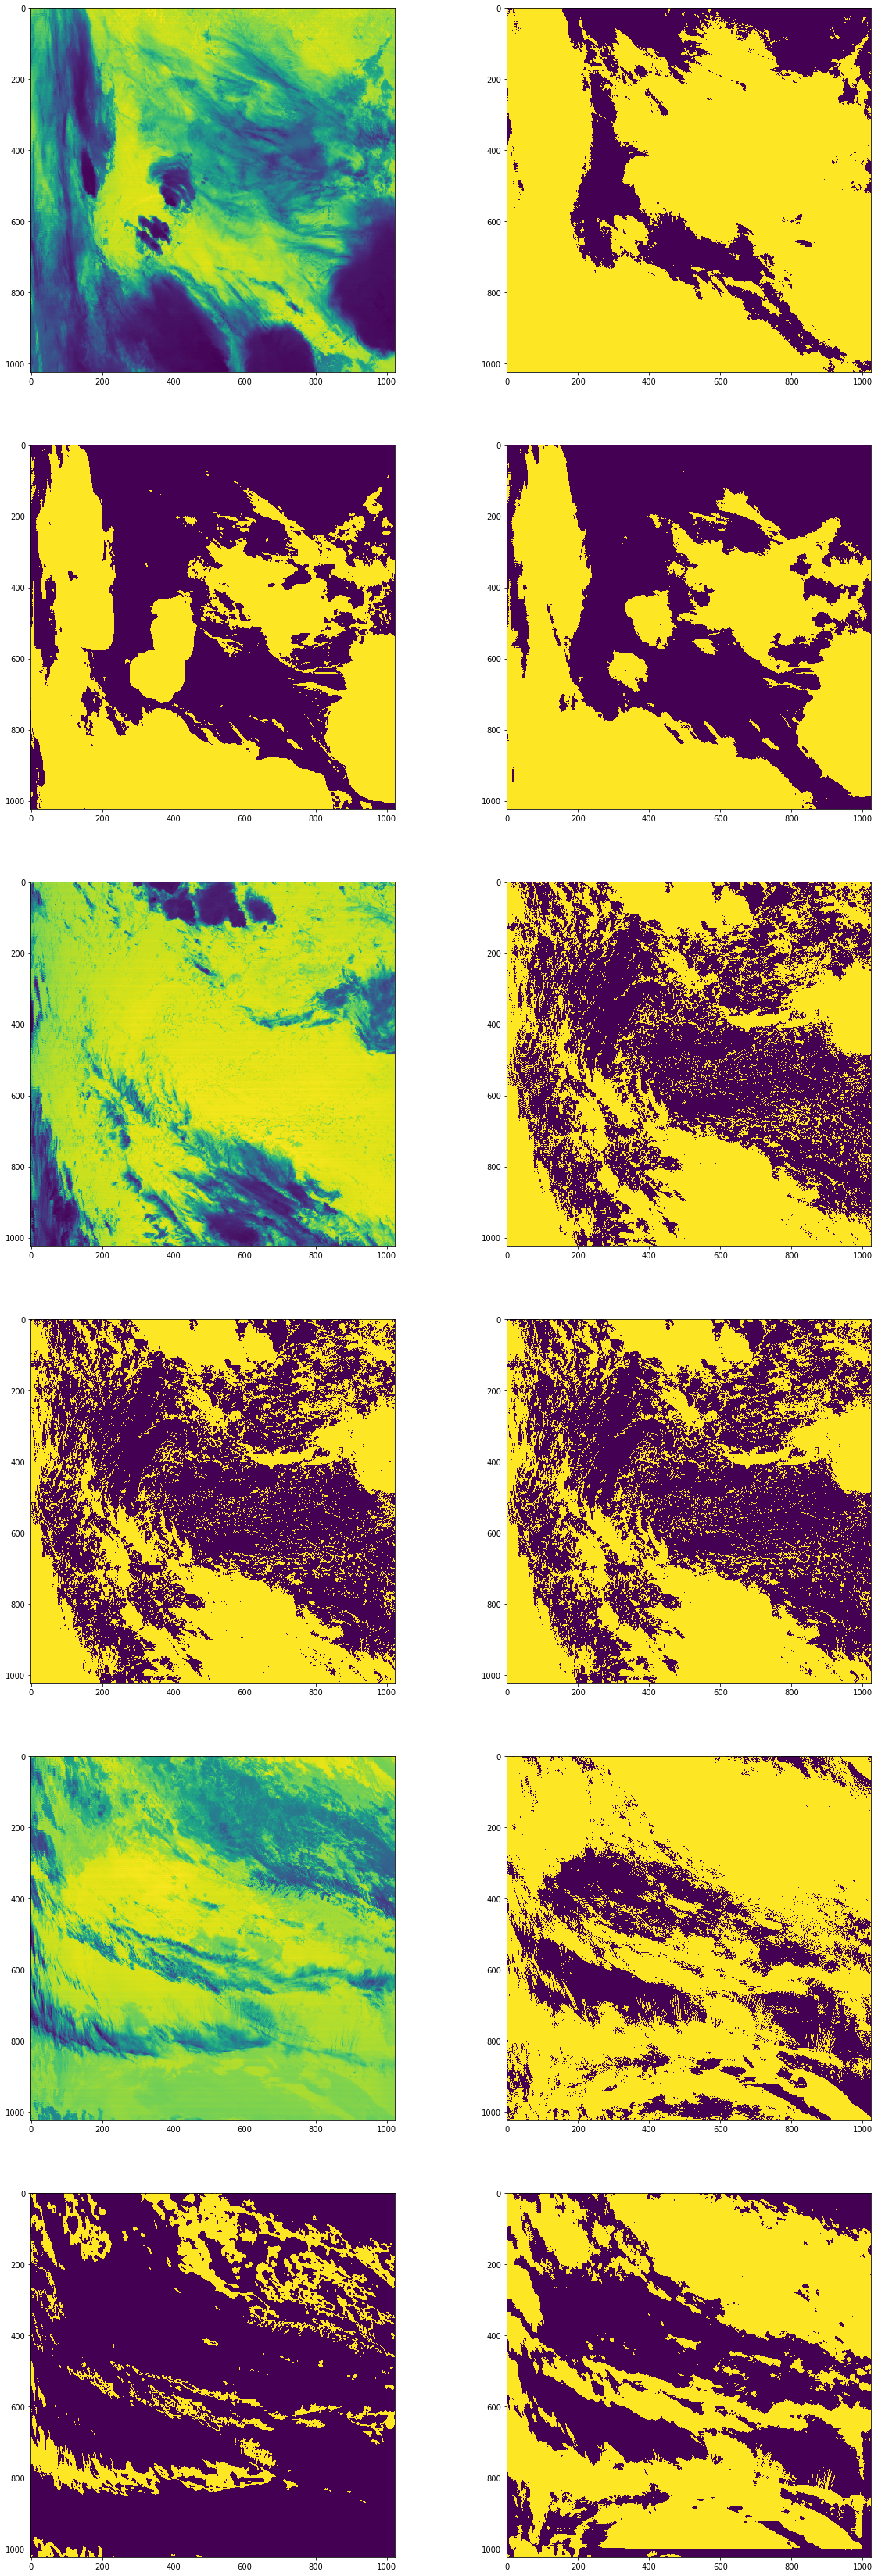

In [ ]:
fig=plt.figure(figsize=(20,60))
rows = len(radiance_data) * 2
for i in range(len(radiance_data)):
  cellstart = (i * 4) + 1
  plt.subplot(rows, 2, cellstart)
  plt.imshow(radiance_data[i][:,:,3])

  plt.subplot(rows, 2, cellstart + 1)
  plt.imshow(mask_data[i])

  plt.subplot(rows, 2, cellstart + 2)
  plt.imshow(stacked_prediction[i][:,:,0]>0.85)

  plt.subplot(rows, 2, cellstart + 3)
  plt.imshow(separate_prediction[i][:,:,0]>0.9)

plt.show()